In [13]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta

In [14]:
# ------------------------------
# 1. Connect to Binance
# ------------------------------
exchange = ccxt.binance({
    'rateLimit': 1200,
    'enableRateLimit': True,
})

symbol = 'BTC/USDT'
timeframe = '1h'


In [15]:
# ------------------------------
# 2. Calculate since timestamp (3 months ago)
# ------------------------------
now = datetime.utcnow()
since = now - timedelta(days=90)  # last 3 months
since_ms = int(since.timestamp() * 1000)


/tmp/ipykernel_17928/4067372233.py:4: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


In [16]:
# ------------------------------
# 3. Fetch OHLCV data
# ------------------------------
ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since_ms, limit=1000)


In [17]:
# ------------------------------
# 4. Create DataFrame
# ------------------------------
df = pd.DataFrame(ohlcv, columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
df['Time'] = pd.to_datetime(df['Time'], unit='ms')
df.set_index('Time', inplace=True)

In [18]:
# ------------------------------
# 5. Save CSV (optional)
# ------------------------------
df.to_csv('btc_1h.csv')
print("Data fetched and saved. Shape:", df.shape)
print(df.head())

Data fetched and saved. Shape: (1000, 5)
                          Open       High        Low      Close      Volume
Time                                                                       
2025-06-27 08:00:00  106869.72  107087.85  106679.98  106998.53   756.49658
2025-06-27 09:00:00  106998.54  107137.64  106786.47  107083.80  1011.48795
2025-06-27 10:00:00  107083.81  107159.95  106953.02  106995.32   328.42336
2025-06-27 11:00:00  106995.33  107147.83  106921.66  106983.60   221.66755
2025-06-27 12:00:00  106983.60  107200.00  106601.64  106692.90   489.40703


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta  # make sure ta is installed: pip install ta


In [20]:
# ------------------------------
# 1. Load CSV
# ------------------------------
CSV_PATH = "btc_1h.csv"  # your Binance CSV file
df = pd.read_csv(CSV_PATH)

# Ensure datetime index
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)

In [21]:
# ------------------------------
# 2. Calculate SMA (3 closes)
# ------------------------------
sma_window = 3
df['SMA'] = ta.trend.sma_indicator(df['Close'], window=sma_window)


In [23]:
df.dropna(inplace=True)  # drop rows with NaN values after SMA calculation

In [24]:
df.head()

,Open,High,Low,Close,Volume,SMA
Time,,,,,,
2025-06-27 10:00:00,107083.81,107159.95,106953.02,106995.32,328.42336,107025.883333
2025-06-27 11:00:00,106995.33,107147.83,106921.66,106983.60,221.66755,107020.906667
2025-06-27 12:00:00,106983.60,107200.00,106601.64,106692.90,489.40703,106890.606667
2025-06-27 13:00:00,106692.89,106982.40,106356.76,106820.99,613.57127,106832.496667
2025-06-27 14:00:00,106821.00,107105.43,106370.44,106557.79,2106.24243,106690.560000


In [25]:
# ------------------------------
# 3. Swing Highs and Lows for labeling
# ------------------------------
lookback = 5  # ±5 candles

def detect_swings(prices, highs, lows, lookback=5):
    labels = np.zeros(len(prices))
    for i in range(lookback, len(prices) - lookback):
        # Swing High
        if highs[i] == max(highs[i-lookback:i+lookback+1]):
            labels[i] = -1  # Downtrend reversal
        # Swing Low
        elif lows[i] == min(lows[i-lookback:i+lookback+1]):
            labels[i] = 1   # Uptrend reversal
    return labels

df['Label'] = detect_swings(df['Close'], df['High'], df['Low'], lookback=lookback)


/tmp/ipykernel_17928/1644204256.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if highs[i] == max(highs[i-lookback:i+lookback+1]):
/tmp/ipykernel_17928/1644204256.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif lows[i] == min(lows[i-lookback:i+lookback+1]):


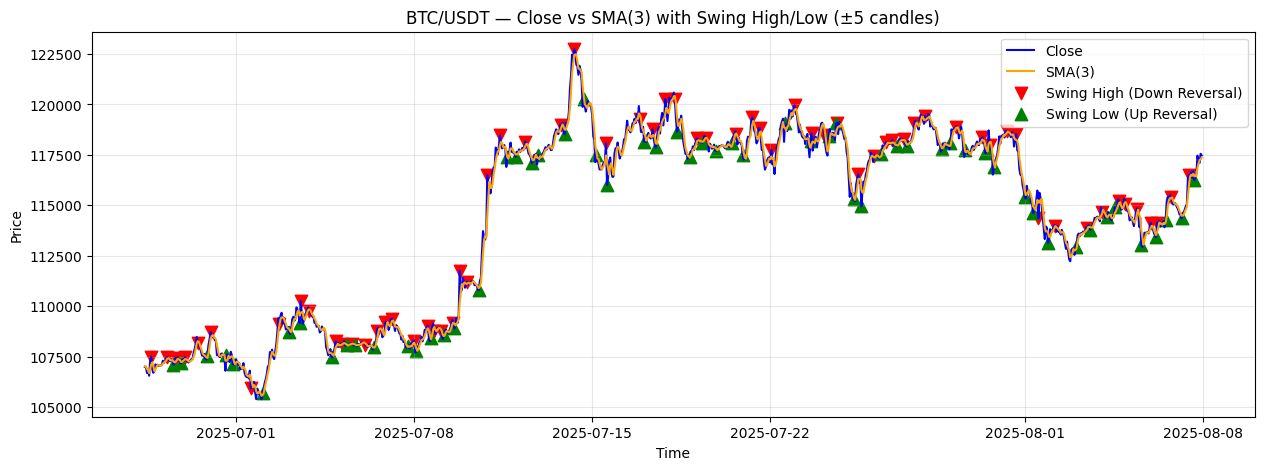

In [26]:
# ------------------------------
# 4. Plot Close, SMA and Swing Points
# ------------------------------
plt.figure(figsize=(15,5))

# Close price
plt.plot(df.index, df['Close'], label='Close', color='blue')

# SMA
plt.plot(df.index, df['SMA'], label=f'SMA({sma_window})', color='orange')

# Swing Highs (down reversals)
plt.scatter(df.index[df['Label']==-1], df['Close'][df['Label']==-1],
            marker='v', color='red', s=80, label='Swing High (Down Reversal)')

# Swing Lows (up reversals)
plt.scatter(df.index[df['Label']==1], df['Close'][df['Label']==1],
            marker='^', color='green', s=80, label='Swing Low (Up Reversal)')

plt.title(f"BTC/USDT — Close vs SMA({sma_window}) with Swing High/Low (±{lookback} candles)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()